# MVP Análise de Dados e Boas Práticas
**Nome:** Pedro Mendes de Azambuja Rodrigues

**Matrícula:**

**Dataset:** [DADOS SUS SINAN_DENGUE (2021-2024)](https://www.kaggle.com/datasets/henriquerezermosqur/dados-sus-sinan-dengue-2021-2024/data)

---



# Descrição do Problema
O dataset DADOS SUS SINAN_DENGUE (2021–2024) contém notificações de casos de dengue no Brasil, com informações clínicas, demográficas, laboratoriais e de desfecho.
O objetivo do projeto é desenvolver um modelo que, com base nas informações disponíveis no momento da notificação, preveja a probabilidade de evolução para formas graves da dengue. Essa abordagem pode contribuir para a estratificação precoce de risco e apoiar a tomada de decisão clínica em contextos de triagem e vigilância.

# Hipótese do problema
A hipótese principal deste estudo é que variáveis disponíveis no momento da apresentaçao do paciente na unidade de saúde, incluindo sinais e sintomas iniciais, presença de comorbidades e características demográficas, contêm informação suficiente para treinar um modelo supervisionado com capacidade discriminativa para prever a evolução clínica de pacientes com dengue. A hipótese será considerada sustentada se o modelo obtiver desempenho preditivo significativamente superior ao acaso, conforme avaliado por métricas apropriadas.

# Tipo de Problema
Trata-se de um problema de classificação supervisionada binária, em que o modelo aprende a prever a evolução do paciente com base em exemplos rotulados. As classes são definidas como:

0 – Não evolui para forma grave

1 – Evolui para forma grave



# Seleção de Dados
Restringi os dados ao ano de 2022 para que as análises pudessem ser executadas no ambiente gratuito do Google Colab, considerando limitações de memória e processamento.

As variáveis de interesse foram selecionadas a partir do banco original para compor a base analítica.

# Atributos do Dataset
O dataset utilizado (filtrado para o ano de 2022 conforme explicado acima) contém 1.395.152 registros e 61 variáveis. Cada linha representa uma notificação individual de caso de dengue. As colunas incluem informações demográficas, clínicas, laboratoriais e de desfecho.

Para a análise e construção do modelo preditivo, foram selecionadas apenas as variáveis com potencial informativo no momento da notificação. Essas variáveis foram agrupadas por categorias temáticas, com suas respectivas descrições conforme o dicionário oficial do dataset.

**1. Dados Demográficos**

Variáveis relacionadas ao perfil sociodemográfico e à notificação:

NU_IDADE_N: Idade do paciente.

CS_SEXO: Sexo do paciente (F para feminino, M para masculino).

CS_RACA: Cor ou raça do paciente.

CS_ESCOL_N: Nível de escolaridade do paciente.

SG_UF_NOT: Sigla do estado onde a notificação foi feita.

**2. Sinais, Sintomas e Exames Laboratoriais**

Manifestações clínicas iniciais que compõem o quadro agudo:

FEBRE: Indica a presença de febre (1 para sim, 2 para não).

MIALGIA: Indica a presença de mialgia (dor muscular).

CEFALEIA: Indica a presença de cefaleia (dor de cabeça).

EXANTEMA: Indica a presença de exantema (erupção cutânea).

VOMITO: Indica a presença de vômito.

NAUSEA: Indica a presença de náusea.

DOR_COSTAS: Indica a presença de dor nas costas.

CONJUNTVIT: Indica a presença de conjuntivite.

ARTRITE: Indica a presença de artrite.

ARTRALGIA: Indica a presença de artralgia (dor nas articulações).

PETEQUIA_N: Indica a presença de petequia (manchas vermelhas na pele).

LEUCOPENIA: Indica a presença de leucopenia (baixa contagem de leucócitos).

LACO: Indica a presença de sinal do laço (prova do laço positiva).

DOR_RETRO: Indica a presença de dor retro-orbitária.

CS_GESTANT: Indica se a paciente é gestante.

**3. Comorbidades**

Condições clínicas pré-existentes com impacto potencial na evolução:

DIABETES: Indica a presença de diabetes.

HEMATOLOG: Indica presença de doenças hematológicas.

HEPATOPAT: Indica presença de hepatopatia.

RENAL: Indica presença de doença renal crônica.

HIPERTENSA: Indica presença de hipertensão arterial.

ACIDO_PEPT: Indica problemas relacionados ao ácido péptico.

AUTO_IMUNE: Indica presença de doenças autoimunes.

**4. Variáveis de Desfecho**

CLASSI_FIN: Classificação final do caso (ex: dengue, dengue grave).

EVOLUCAO: Evolução do caso (cura, óbito, etc.).

A maioria das variáveis categóricas está codificada numericamente. Por exemplo para as binárias: Sim = 1 Não = 2. As etiquetas (labels) estão disponíveis no dicionário de dados disponível na [página do dataset](https://www.kaggle.com/datasets/henriquerezermosqur/dados-sus-sinan-dengue-2021-2024/data) e serão introduzidas durante o tratamento dos dados, ao longo da análise explorarória.

As variáveis de desfecho serão combinadas para produzir uma variável de classificação binária, confome descrito abaixo.



# Importação das Bibliotecas Necessárias e Carga de Dados
Esta seção consolida todas as importações de bibliotecas necessárias para a análise, visualização e pré-processamento dos dados, bem como o carregamento inicial do dataset.

In [1]:
!pip install dython

In [65]:
import sqlite3
import pandas as pd
import numpy as np
import kagglehub
import os
import seaborn as sns
import matplotlib.pyplot as plt
from dython.nominal import associations
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate

In [3]:
### Download do dataset via API do Kaggle, filtragem os registros de 2022 e carregamento em um DataFrame ###

# Download do banco de dados do Kaggle
path = kagglehub.dataset_download("henriquerezermosqur/dados-sus-sinan-dengue-2021-2024")

# Definição do caminho para o arquivo .db
db_file = os.path.join(path, 'SINAN_DENGUE.db')

# Conexão com o banco de dados SQLite
conn = sqlite3.connect(db_file)

# Consultar registros de 2022
query = """
SELECT *
FROM SINAN_DENGUE
WHERE NU_ANO = 2022
"""
# Carregar resultado em DataFrame
df = pd.read_sql_query(query, conn)

# Inspeção inicial dos dados
print(f"Registros carregados: {df.shape[0]} linhas e {df.shape[1]} colunas")

# Fechar conexão com o banco de dados
conn.close()


Registros carregados: 1395152 linhas e 61 colunas


In [4]:
# Primeiras linhas
df.head()

,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,...,COMUNINF,CLASSI_FIN,CRITERIO,EVOLUCAO,DT_OBITO,DT_ENCERRA,TP_SISTEMA,DT_DIGITA,CS_FLXRET,TARGET_OBITO
0,2,A90,2022-01-05 00:00:00.000000,202201,2022,12,120033,1941.0,9542566.0,2022-01-01 00:00:00.000000,...,None,5.0,1.0,NaN,None,2022-01-28 00:00:00.000000,2.0,2022-03-16 00:00:00.000000,None,0
1,2,A90,2022-01-06 00:00:00.000000,202201,2022,12,120020,1941.0,6801099.0,2022-01-01 00:00:00.000000,...,None,5.0,1.0,1.0,None,2022-01-12 00:00:00.000000,2.0,2022-01-12 00:00:00.000000,None,0
2,2,A90,2022-01-06 00:00:00.000000,202201,2022,12,120020,1941.0,6801099.0,2021-12-31 00:00:00.000000,...,None,10.0,1.0,1.0,None,2022-01-11 00:00:00.000000,2.0,2022-01-11 00:00:00.000000,None,0
3,2,A90,2022-01-03 00:00:00.000000,202201,2022,12,120020,1941.0,6801099.0,2021-12-31 00:00:00.000000,...,None,10.0,1.0,1.0,None,2022-01-06 00:00:00.000000,2.0,2022-01-06 00:00:00.000000,None,0
4,2,A90,2022-01-19 00:00:00.000000,202203,2022,12,120020,1941.0,6788637.0,2022-01-01 00:00:00.000000,...,None,5.0,1.0,1.0,None,2022-01-25 00:00:00.000000,2.0,2022-01-20 00:00:00.000000,None,0


# Análise de Dados
Nesta etapa de Análise de Dados Exploratória (EDA) sobre o dataset, visamos entender a distribuição, as relações e as características das variáveis, o que é crucial para as etapas subsequentes de pré-processamento e modelagem.


# Total e Tipo das Instâncias

O dataset possui 1.395.152 registros e 61 variáveis.

Algumas obsevações:

- Variáveis categóricas estão codificadas. Rótulos descritivos serão introduzidos nas variáveis selecionadas durante a análise.

- A variável idade (NU_IDADE_N) também está codificada, e será convertida para idade em anos adiante.

- Datas estão como object e não serão convertidas para datetime porque essas variáveis não serão utilizadas.

- Há colunas com todos os valores faltentes, que não correspondem às variáveis de interesse.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395152 entries, 0 to 1395151
Data columns (total 61 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   TP_NOT        1395152 non-null  int64  
 1   ID_AGRAVO     1395152 non-null  object 
 2   DT_NOTIFIC    1395152 non-null  object 
 3   SEM_NOT       1395152 non-null  int64  
 4   NU_ANO        1395152 non-null  int64  
 5   SG_UF_NOT     1395152 non-null  int64  
 6   ID_MUNICIP    1395152 non-null  int64  
 7   ID_REGIONA    1281550 non-null  float64
 8   ID_UNIDADE    1395093 non-null  float64
 9   DT_SIN_PRI    1395100 non-null  object 
 10  SEM_PRI       1395152 non-null  int64  
 11  ANO_NASC      1388005 non-null  float64
 12  NU_IDADE_N    1395152 non-null  int64  
 13  CS_SEXO       1395127 non-null  object 
 14  CS_GESTANT    1394761 non-null  float64
 15  CS_RACA       1395120 non-null  float64
 16  CS_ESCOL_N    1107715 non-null  float64
 17  SG_UF         1395152 non-n

## Definiçao das classes (desfecho):
Para a definicáo das classes, selecionamos duas variáveis: Classificação final do caso (CLASSI_FIN) e Evolução do caso (EVOLUCAO). Essas variáveis capturam a evolução para forma grave e desfechos desvavoráveis associados e serão combinadas para a nova variável de classificação.   

### Variável Classificação final (CLASSI_FIN)

A variável foi rotulada de acordo com o dicionário de dados. As nossas categorias de interesse são:
- Para o desfecho grave: Dengue grave
- Para o desfecho de dengue sem gravidade: Dengue, Dengue com sinais de alarme

As categorias Inconclusivo, NaN e Descartado não serão aproveitadas, pos representam casos em que o diagnóstico de dengue não foi atribuído.

Observação: Dengue com sinais de alarme não representa uma forma clínica grave da Dengue

In [7]:

# Rótulos

classi_fin_map = {
    5:  'Descartado',
    8:  'Inconclusivo',
    10: 'Dengue',
    11: 'Dengue com sinais de alarme',
    12: 'Dengue grave',
    13: 'Chikungunya'
}

# Cria uma nova variável rotulada

df['CLASSI_FIN_LABEL'] = df['CLASSI_FIN'].map(classi_fin_map)

# Distribuiçao de frequencias da variável rotulada

print(f"Frequência das categorias da variável Classificacão Final")

df['CLASSI_FIN_LABEL'].value_counts(dropna=False)

Frequência das categorias da variável Classificacão Final


,count
CLASSI_FIN_LABEL,
Dengue,1223671
Inconclusivo,149176
Dengue com sinais de alarme,18660
Dengue grave,1541
NaN,1483
Descartado,621


### Variável Evolução do caso (EVOLUCAO)
A variável foi rotulada de acordo com o dicionário de dados. As categorias de interesse são:
- Para o desfecho de dengue com gravidade: Óbito por dengue.
- Para o desfecho de dengue sem gravidade: Cura ou Óbito por outras causas

O restante das categorias não será aproveitado, pois representam casos com desfecho infefinido


In [8]:
# Rótulos
evolucao_map = {
    1: 'Cura',
    2: 'Óbito por dengue',
    3: 'Óbito por outras causas',
    4: 'Óbito em investigação',
    9: 'Ignorado'
}

# Cria uma nova variável rotulada
df['EVOLUCAO_LABEL'] = df['EVOLUCAO'].map(evolucao_map)

#  Distribuiçao de frequencias da variável rotulada
print(f"Frequência das categorias da variável Evolução")

df['EVOLUCAO_LABEL'].value_counts(dropna=False)

Frequência das categorias da variável Evolução


,count
EVOLUCAO_LABEL,
Cura,1141939
NaN,198148
Ignorado,53557
Óbito por dengue,1052
Óbito por outras causas,392
Óbito em investigação,64


### Tabela cruzada entre evolução do caso e classificação final.
Nessa tabela podemos ver a relação entre as variávies e como as categorias de interesse podem ser complementares.

In [9]:
# Tabela cruzada
print (f"Tabela cruzada entre  as variáveis Evolução e Classificação Final")

pd.crosstab(df['EVOLUCAO_LABEL'], df['CLASSI_FIN_LABEL'])

Tabela cruzada entre  as variáveis Evolução  e Classificação Final


CLASSI_FIN_LABEL,Dengue,Dengue com sinais de alarme,Dengue grave,Descartado,Inconclusivo
EVOLUCAO_LABEL,,,,,
Cura,1121127,16778,599,536,2893
Ignorado,51780,785,66,25,901
Óbito em investigação,21,19,11,0,13
Óbito por dengue,222,99,729,0,2
Óbito por outras causas,279,52,54,2,5


### Criação da variável de classificação
Na nova variável de classificaçao, o paciente é classificado como tendo o desfecho de dengue com gravidade (cód. 1) caso apresente a classificação final de dengue grave (cód. 12), ou a evolução de óbito por dengue (cód 2). A classe de dengue sem gravidade (cod. 0) foi definida como classificação final como dengue (cód 10) ou dengue com sinais de alarme (cód 11) ou evolução do caso para cura (cód 1) óbito por outras causas (cód 3)

In [10]:
# Criaçao da coluna da variável de classificaçao
df['CLASS'] = np.nan

# Definiçao das classes
df.loc[(df['CLASSI_FIN'] == 12) | (df['EVOLUCAO'] == 2), 'CLASS'] = 1

df.loc[(df['CLASSI_FIN'].isin([10, 11])) & (df['EVOLUCAO'].isin([1, 3])), 'CLASS'] = 0

In [11]:
contagem = df['CLASS'].value_counts()

print(f"Pacientes com desfecho de dengue com gravidade: {contagem.get(1, 0)}")

print(f"Pacientes com desfecho de dengue sem gravidade: {contagem.get(0, 0)}")

Pacientes com desfecho de dengue com gravidade: 1864
Pacientes com desfecho de dengue sem gravidade: 1138236


### Removendo os pacientes que não correspondem às classes de desfecho

Esses pacientes não tiveram o diagnóstico de dengue definido ou tem a evolução final desconhecida e serão exluidos do dataset.

In [12]:
print(f"Pacientes que não correspondem às definicões das classes: {df['CLASS'].isna().sum()}")

Pacientes que não correspondem às definicões das classes: 255052


In [13]:
# Remover NA
df = df.dropna(subset=['CLASS'])

# Verificar contagem de NA depois (deve ser 0)
print(f"Pacientes que não correspondem às definições das classes após a remoção: {df['CLASS'].isna().sum()}")

Pacientes que não correspondem às definições das classes após a remoção: 0


Agora vamos contar a frequencia absoluta e porcentagem das classes após a remoção dos valores faltentes

In [14]:
# frequencia absoluta e porcentagem das classes
abs_freq = df['CLASS'].value_counts()
rel_freq = df['CLASS'].value_counts(normalize=True) * 100

freq_table = pd.concat([abs_freq, rel_freq], axis=1)
freq_table.columns = ['Frequência', 'Porcentagem (%)']

print(f"\n===Variável de classificação ('CLASS'):===")
print(freq_table.to_string())



===Variável de classificação ('CLASS'):===
       Frequência  Porcentagem (%)
CLASS                             
0.0       1138236        99.836506
1.0          1864         0.163494


Podemos observar que há um importante desbalanceamento das classes, que será abordado no pré-processamento adiante

## Análise de variáves demográficas:

Variáveis relacionadas ao perfil sociodemográfico e à notificação:

NU_IDADE_N: Idade do paciente.

CS_SEXO: Sexo do paciente (F para feminino, M para masculino).

CS_GESTANT: Indica se a paciente é gestante.

CS_RACA: Cor ou raça do paciente.

CS_ESCOL_N: Nível de escolaridade do paciente.

SG_UF_NOT: Sigla do estado onde a notificação foi feita.

### Decodificando a idade em anos

A variável NU_IDADE_N do SINAN representa a idade do paciente no momento dos primeiros sintomas codificada em um formato especial de quatro dígitos:

Formato: AXXX
O primeiro dígito (A) indica a unidade de tempo:

1 = horas; 2 = dias; 3 = meses; 4 = anos

Os três dígitos seguintes (XXX) indicam a quantidade da unidade de tempo.

Exemplos:
3009 → 9 meses de idade; 4018 → 18 anos de idade; 2005 → 5 dias de idade; 1050 → 50 horas de vida

Em seguida vou criar uma nova variável representado a idade em anos

In [15]:
# funcão para conversão da idade em anos:
def converter_idade(idade_code):
    # Converte para string com zeros à esquerda (garante 4 dígitos)
    idade_str = f"{idade_code:04d}"
    unidade = int(idade_str[0])
    quantidade = int(idade_str[1:])

    if unidade == 1:     # horas
        idade_em_anos = quantidade / (24 * 365)
    elif unidade == 2:   # dias
        idade_em_anos = quantidade / 365
    elif unidade == 3:   # meses
        idade_em_anos = quantidade / 12
    elif unidade == 4:   # anos
        idade_em_anos = quantidade
    else:
        idade_em_anos = None  # valor indefinido em caso de código inesperado

    return idade_em_anos

# Cria a nova coluna com a idade em anos
df['idade_anos'] = df['NU_IDADE_N'].apply(converter_idade)



Primeiras linhas da variável criada representado a idade em anos

In [17]:
# Variável idade em anos
print(f"Variável idade em anos")

df['idade_anos'].head()

Variável idade em anos


,idade_anos
2,15.0
3,38.0
6,32.0
7,41.0
9,22.0


### Limpeza da variável idade em anos
Podemos ver ao gerar a estatística descritiva da variável que os valores mínimo (0) e máximo (407) representam erros na entrada dos dados

In [18]:
# Estatistíca descritiva de idade_anos
print(f" Estatística descritiva da variável Idade em anos")

df['idade_anos'].describe()

 Estatística descritiva da variável idade em anos


,idade_anos
count,1.140007e+06
mean,3.524331e+01
std,1.984584e+01
min,0.000000e+00
25%,2.000000e+01
50%,3.400000e+01
75%,4.900000e+01
max,4.070000e+02


 O boxplot nos ajuda a visualizar valores discrepantes


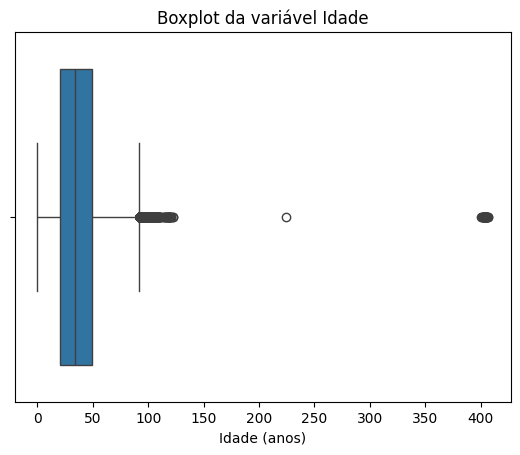

In [20]:
# Boxplot da variável idade_anos
sns.boxplot(x=df["idade_anos"])
plt.title("Boxplot da variável Idade")
plt.xlabel('Idade (anos)')
plt.show()

#### Exclusão de dados errôneos
Foram excluídas as entradas com idade igual a 0 ou superior a 105 anos, por serem valores inconsistentes ou biologicamente implausíveis. Idades acima de 105 anos, embora teoricamente possíveis, são raríssimas e geralmente refletem erros de digitação ou preenchimento. Essa limpeza visa garantir a consistência dos dados e evitar viés em análises demográficas ou modelagens preditivas.

Quantificação dos pacientes a serem excluidos

In [21]:
print(f"Número de pacientes com idade superior a 105 anos: {df[df['idade_anos'] > 105].shape[0]}")


Número de pacientes com idade superior a 105 anos: 83


In [22]:
print(f"Número de pacientes com idade igual a 0: {df[df['idade_anos'] == 0].shape[0]}")


Número de pacientes com idade igual a 0: 7


Exclusão dos pacientes

In [23]:
df = df.drop(df[(df["idade_anos"] == 0) | (df["idade_anos"] > 105)].index)

### Análise da variável idade em anos

Estatística descritiva da variável idade_anos após a limpeza

In [24]:
df['idade_anos'].describe()

,idade_anos
count,1.139917e+06
mean,3.523093e+01
std,1.975719e+01
min,5.707763e-04
25%,2.000000e+01
50%,3.400000e+01
75%,4.900000e+01
max,1.050000e+02


Boxplot da variável após a limpeza

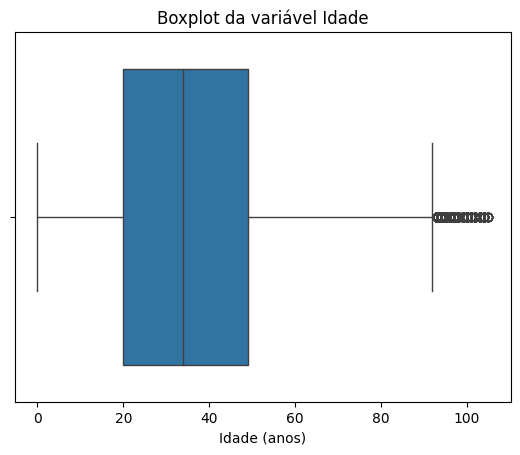

In [25]:
# Boxplot da variável idade_anos
sns.boxplot(x=df["idade_anos"])
plt.title("Boxplot da variável Idade")
plt.xlabel('Idade (anos)')
plt.show()

O histograma demosntra a distribuiçao da idade. A curva de densidade estimada (KDE) nos indica que a distribuição parece aproximadamente unimodal e assimétrica à direita. A maior concentraçao está na faixa de 20 a 30 anos, com frequência decrescente a partir do 40 anos.

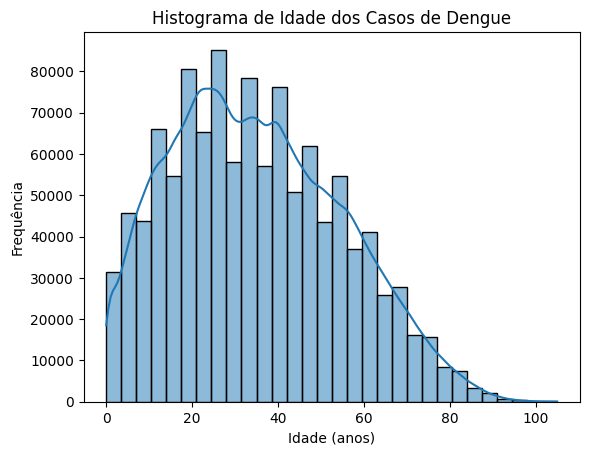

In [27]:
# Histograma de idade_anos
sns.histplot(df['idade_anos'], bins=30, kde = True)
plt.xlabel('Idade (anos)')
plt.ylabel('Frequência')
plt.title('Histograma de Idade dos Casos de Dengue')
plt.show()

### Criaçao da variável de faixas etárias
Discretizando a idade em faixas etárias para análise

In [32]:
# Definiçao das faixas etárias

bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, float('inf')]
labels = ["<1", "1–4", "5–9", "10–19", "20–29", "30–39", "40–49", "50–59", "60-69", "70-79", "80+"]

# Criaçao da variável a partir da idade em anos
df["faixa_etaria"] = pd.cut(df["idade_anos"], bins=bins, labels=labels, right=False)




In [33]:
# Frequencias das faixas etárias
print(f"Frequências das faixas etárias")

df["faixa_etaria"].value_counts(sort=False, dropna = False)

Frequências das faixas etárias


,count
faixa_etaria,
<1,10279
1–4,30927
5–9,63982
10–19,175119
20–29,211752
30–39,193965
40–49,169234
50–59,135424
60-69,88579


Em seguida vamos visualizar o percentual de casos graves (de acordo com a variável de classificação) pela faixa etária. Podemos ver que existem dois picos gravidade: o primeiro em pacientes com menos de 1 ano e o segundo em pacientes idosos, particularmente a partir dos 80 anos.

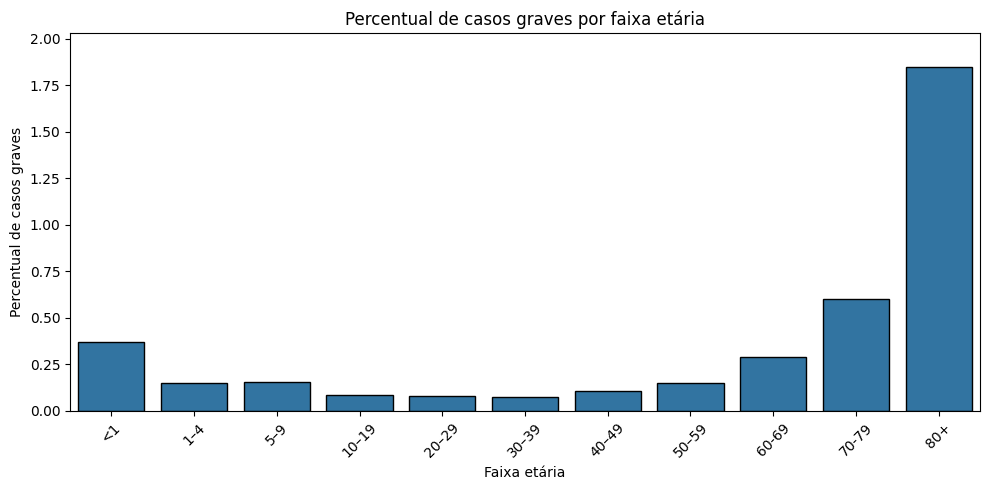

In [35]:
# Calcular total, graves e percentual por faixa etária
perc = (
    df.groupby("faixa_etaria", observed=False)["CLASS"]
      .agg(total="count", graves="sum")
      .assign(percent=lambda x: 100 * x["graves"] / x["total"])
      .reset_index()
)


# Barplot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=perc,
    x="faixa_etaria",
    y="percent",
    edgecolor="black"
)
plt.ylabel("Percentual de casos graves")
plt.xlabel("Faixa etária")
plt.title("Percentual de casos graves por faixa etária")
plt.xticks(rotation=45)
plt.ylim(0, perc["percent"].max() * 1.1)
plt.tight_layout()
plt.show()


## Variáveis sociodemográficas categóricas
Exceto pela idade, o restante das variáveis sociodemográficas é categórica. A seguir, essas variáveis serão rotuladas de acordo com dicionário de dados e as frequencias de cada categoria serão exibidas.

### Criaçao das variáveis sociodemográficas rotuladas

In [36]:
# Rótulos
sexo_map = {
    'F': 'Feminino',
    'M': 'Masculino',
    'I': np.nan
}

raca_map = {
    1.0: 'Branca',
    2.0: 'Preta',
    3.0: 'Amarela',
    4.0: 'Parda',
    5.0: 'Indígena',
    9.0: np.nan
}

escolaridade_map = {
    0.0: np.nan,
    1.0: '1ª a 4ª série incompleta do EF',
    2.0: '4ª série completa do EF',
    3.0: '5ª a 8ª série incompleta do EF',
    4.0: 'Ensino fundamental completo',
    5.0: 'Ensino médio incompleto',
    6.0: 'Ensino médio completo',
    7.0: 'Superior incompleto',
    8.0: 'Superior completo',
    9.0: np.nan,
    10.0: 'Não se aplica (idade < 7 anos)'
}

uf_map = {
    11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
    21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE', 29: 'BA',
    31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP',
    41: 'PR', 42: 'SC', 43: 'RS',
    50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'
}

# Criacáo das variáveis rotuladas
df['CS_SEXO_LABEL'] = df['CS_SEXO'].map(sexo_map)

df['CS_RACA_LABEL'] = df['CS_RACA'].map(raca_map)

df['CS_ESCOL_N_LABEL'] = df['CS_ESCOL_N'].map(escolaridade_map)

df['SG_UF_NOT_LABEL'] = df['SG_UF_NOT'].map(uf_map)



### Frequência absoluta e porcentagem das catgorias de cada variável rotulada

In [37]:
# Dicionário: nome da coluna: rótulo publicável
var_labels = {
    "CS_SEXO_LABEL":      "Sexo",
    "CS_RACA_LABEL":      "Raça/Cor",
    "CS_ESCOL_N_LABEL":   "Escolaridade",
    "SG_UF_NOT_LABEL":    "Unidade Federativa da Notificação",
}

# Lista de variáveis categóricas
cat_vars2 = ['CS_SEXO_LABEL', 'CS_RACA_LABEL', 'CS_ESCOL_N_LABEL', 'SG_UF_NOT_LABEL']

# Exibir frequências de cada categoria com contagem e porcentagem
for var in cat_vars2:
    print(f"\n=== {var_labels.get(var, var)} ({var}) ===")
    abs_freq = df[var].value_counts(dropna=False)
    rel_freq = df[var].value_counts(normalize=True, dropna=False) * 100
    freq_table = (
        pd.DataFrame({
            'Frequência': abs_freq,
            'Porcentagem (%)': rel_freq.round(2)
        })
        .rename_axis(var_labels.get(var, var))
    )

    print(freq_table)



=== Sexo (CS_SEXO_LABEL) ===
           Frequência  Porcentagem (%)
Sexo                                  
Feminino       617009            54.12
Masculino      522013            45.79
NaN               988             0.09

=== Raça/Cor (CS_RACA_LABEL) ===
          Frequência  Porcentagem (%)
Raça/Cor                             
Branca        497764            43.66
Parda         397108            34.83
NaN           202141            17.73
Preta          31213             2.74
Amarela         9025             0.79
Indígena        2759             0.24

=== Escolaridade (CS_ESCOL_N_LABEL) ===
                                Frequência  Porcentagem (%)
Escolaridade                                               
NaN                                 561539            49.26
Ensino médio completo               191251            16.78
Não se aplica (idade < 7 anos)       76990             6.75
5ª a 8ª série incompleta do EF       62803             5.51
Ensino médio incompleto             

Observações:

- Missings altos em raça e escolaridade:
 - CS_RACA_LABEL (17 %)

 - CS_ESCOL_N_LABEL (aprox. 50 % NA)

Como são importantes determinantes socias de saúde, apesar do número alto de missings não serão em princípio excluídas. O tratamento dessas variáveis será realizado na etapa de pré-processamento.

- Frequencias baixas em Raça: Preta (2,74 %), Amarela (0,79 %), Indígena (0,24 %)

Como a raça também pode ser um importante determinante social de desfecho vou manter essas categorias separadas, ao invés de junta-las em "outros".

**Barplot representando a variável Sexo**, demontrando equilibrio entre as categorias

<Axes: xlabel='CS_SEXO_LABEL', ylabel='count'>

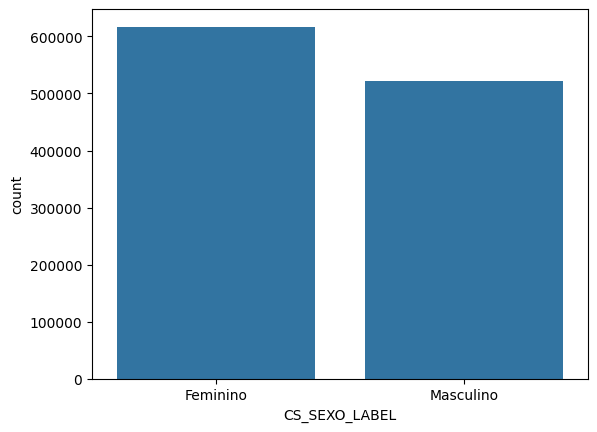

In [38]:
# Barplot da variavel Sexo
sns.countplot(df, x= 'CS_SEXO_LABEL',
              order=df['CS_SEXO_LABEL'].value_counts().index)

**Barplot demonstrando as frequencias das categorias de Raça/Cor**. As raças amarela e indígena apresentam baixa frequência, mas não serão concatenadas, conforme explicado acima.

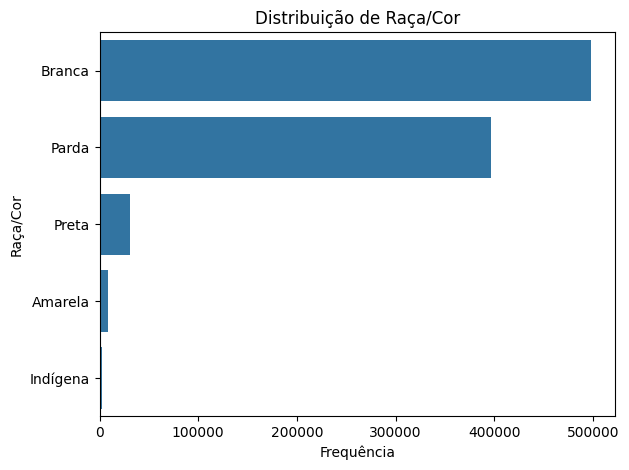

In [39]:
# Barplot da variável Raça
sns.countplot(y='CS_RACA_LABEL',
                   data=df,
                   order=df['CS_RACA_LABEL'].value_counts().index)
plt.title('Distribuição de Raça/Cor')
plt.xlabel('Frequência')
plt.ylabel('Raça/Cor')
plt.tight_layout()
plt.show()

**Barplot demonstrando a distribuição das categorias de escolaridade**. A categoria mais frequente é de indivíduos com ensino médico completo, seguida por idade < 7 anos. Conforme comentado acima a proporção de missings é alta, o que vai requerer tratamento do dado no pré-processamento.


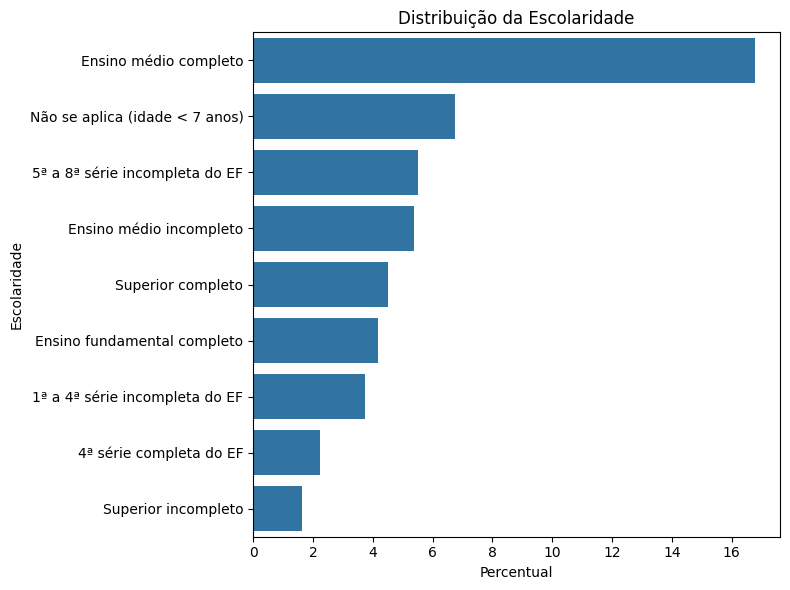

In [40]:
# Barplot da variável escolaridade
plt.figure(figsize=(8, 6))
sns.countplot(y='CS_ESCOL_N_LABEL', stat = "percent",
                   data=df,
                   order=df['CS_ESCOL_N_LABEL'].value_counts().index)
plt.title('Distribuição da Escolaridade')
plt.xlabel('Percentual')
plt.ylabel('Escolaridade')
plt.tight_layout()
plt.show()

### Recategoriação da variável de escolaridade
As categorias foram simplificadas, agrupando as que representam o ensino fundamental incompleto. Para o modelo, a informação da categoria < 7 anos já estará contida na variável de idade.

In [41]:
# Recategoriação da variável de escolaridade

# Mapeamento
map_escol = {
    'Não se aplica (idade < 7 anos)': 'EF incompleto',
    '1ª a 4ª série incompleta do EF': 'EF incompleto',
    '4ª série completa do EF':       'EF incompleto',
    '5ª a 8ª série incompleta do EF': 'EF incompleto',
    'Ensino fundamental completo':    'EF completo',
    'Ensino médio incompleto':  'EM incompleto',
    'Ensino médio completo':    'EM completo',
    'Superior incompleto':      'Superior incompleto',
    'Superior completo':        'Superior completo'
}

# Aplicação da  recodificação
df['ESCOL_ORD'] = (
    df['CS_ESCOL_N_LABEL']
      .map(map_escol)
)

# Ordernar as categorias
ordem = [
    'EF incompleto', 'EF completo',
    'EM incompleto', 'EM completo',
    'Superior incompleto', 'Superior completo'
]
df['ESCOL_ORD'] = pd.Categorical(df['ESCOL_ORD'], categories=ordem, ordered=True)


**Frequencia das novas categorias**

In [42]:
# Frequencias da variável escolaridade retategorizada
print (f"Frequencias da variável escolaridade retategorizada")

df['ESCOL_ORD'].value_counts(dropna = False)

Frequencias da variável escolaridade retategorizada


,count
ESCOL_ORD,
NaN,561539
EF incompleto,208037
EM completo,191251
EM incompleto,61411
Superior completo,51550
EF completo,47730
Superior incompleto,18492


**Boxplot da variável escolaridade recategorizada**. Podemos observar que a categoria mais frequente passa a ser e de ensino fundamental incompleto

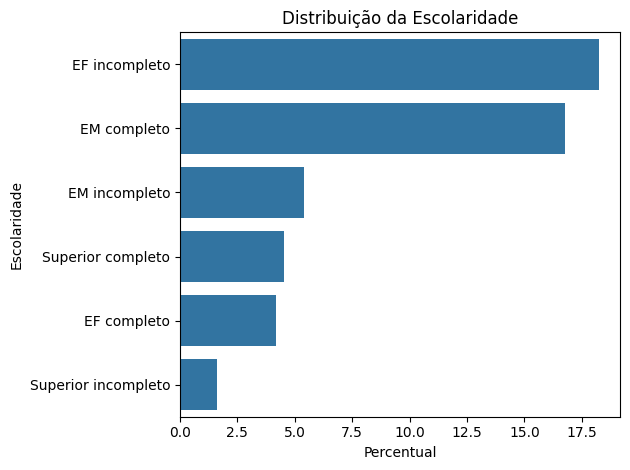

In [43]:
sns.countplot(data = df,
              y="ESCOL_ORD",
              order=df['ESCOL_ORD'].value_counts().index,
              stat = 'percent')
plt.title('Distribuição da Escolaridade')
plt.xlabel('Percentual')
plt.ylabel('Escolaridade')
plt.tight_layout()
plt.show()

**Barplot representando a distribuição das notificações nas unidades federativas**

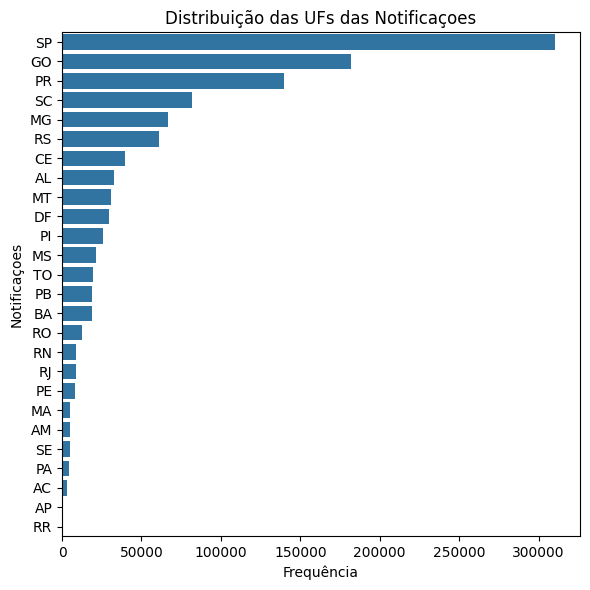

In [44]:
# Barplot das notificaçoes por unidade federativa
plt.figure(figsize=(6, 6))
sns.countplot(y='SG_UF_NOT_LABEL',
                   data=df,
                   order=df['SG_UF_NOT_LABEL'].value_counts().index)
plt.title('Distribuição das UFs das Notificaçoes')
plt.xlabel('Frequência')
plt.ylabel('Notificaçoes')
plt.tight_layout()
plt.show()

## Análise das variáveis do grupo das comorbidades

Condições clínicas pré-existentes com impacto potencial na evolução:

DIABETES: Indica a presença de diabetes.

HEMATOLOG: Indica presença de doenças hematológicas.

HEPATOPAT: Indica presença de hepatopatia.

RENAL: Indica presença de doença renal crônica.

HIPERTENSA: Indica presença de hipertensão arterial.

ACIDO_PEPT: Indica problemas relacionados ao ácido péptico.

AUTO_IMUNE: Indica presença de doenças autoimunes.

CS_GESTANT: Indica se a paciente é gestante. A gestacáo não é uma comorbidade mas está nesse grupo por representar uma condição especial de saúde.

In [45]:
# Rotulos das variáveis do grupo das comorbidades
# Mapeamentos
map_binario = {1: 'Sim', 2: 'Não', 9: np.nan}
map_gestante = {
    1: '1º trimestre',
    2: '2º trimestre',
    3: '3º trimestre',
    4: 'Idade gestacional ignorada',
    5: 'Não',
    6: 'Não se aplica',
    9: np.nan
}

# Aplicar os mapeamentos
df['CS_GESTANT_LABEL'] = df['CS_GESTANT'].map(map_gestante)

for var in ['DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL',
            'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE']:
    df[f'{var}_LABEL'] = df[var].map(map_binario)


### Frequencias absolutas e porcentagens das categorias das variávies do grupo das comorbidades

Podemos observar que todas as variáves são binárias (sim/não) exceto pela variável que indica gestação.

In [46]:
# Frequencias absolutas e porcentagens das categorias das variávies do grupo das comorbidades
# Dicionário com nomes legíveis para as variáveis
var_labels = {
    "CS_GESTANT_LABEL":  "Gestante",
    "DIABETES_LABEL":    "Diabetes",
    "HEMATOLOG_LABEL":   "Doença hematológica",
    "HEPATOPAT_LABEL":   "Doença hepática",
    "RENAL_LABEL":       "Doença renal",
    "HIPERTENSA_LABEL":  "Hipertensão",
    "ACIDO_PEPT_LABEL":  "Doença ácido-péptica",
    "AUTO_IMUNE_LABEL":  "Doença autoimune",
}

# Lista das variáveis rotuladas
comorb_vars2 = [
    'CS_GESTANT_LABEL',
    'DIABETES_LABEL',
    'HEMATOLOG_LABEL',
    'HEPATOPAT_LABEL',
    'RENAL_LABEL',
    'HIPERTENSA_LABEL',
    'ACIDO_PEPT_LABEL',
    'AUTO_IMUNE_LABEL'
]

# Loop para mostrar as frequências de cada variável
for var in comorb_vars2:
    print(f"\n=== {var_labels.get(var, var)} ({var}) ===")
    abs_freq = df[var].value_counts(dropna=False)
    rel_freq = df[var].value_counts(normalize=True, dropna=False) * 100
    freq_table = (
        pd.DataFrame({
            'Frequência': abs_freq,
            'Porcentagem (%)': rel_freq.round(2)
        })
        .rename_axis(var_labels.get(var, var))
    )

    print(freq_table)



=== Gestante (CS_GESTANT_LABEL) ===
                            Frequência  Porcentagem (%)
Gestante                                               
Não se aplica                   635569            55.75
Não                             411882            36.13
NaN                              83437             7.32
2º trimestre                      2843             0.25
1º trimestre                      2397             0.21
3º trimestre                      2283             0.20
Idade gestacional ignorada        1599             0.14

=== Diabetes (DIABETES_LABEL) ===
          Frequência  Porcentagem (%)
Diabetes                             
Não          1099566            96.45
Sim            40393             3.54
NaN               51             0.00

=== Doença hematológica (HEMATOLOG_LABEL) ===
                     Frequência  Porcentagem (%)
Doença hematológica                             
Não                     1133915            99.47
Sim                        6044         

**Barplot da variável de situaçao gestacional.** Podemos observar no grafico e na tabela acima que as gestantes representam uma proporçao pequena dos casos. Por isso vou prosseguir com o agrupamento das categorias para criar uma variável binária (sim/não) para gestação.

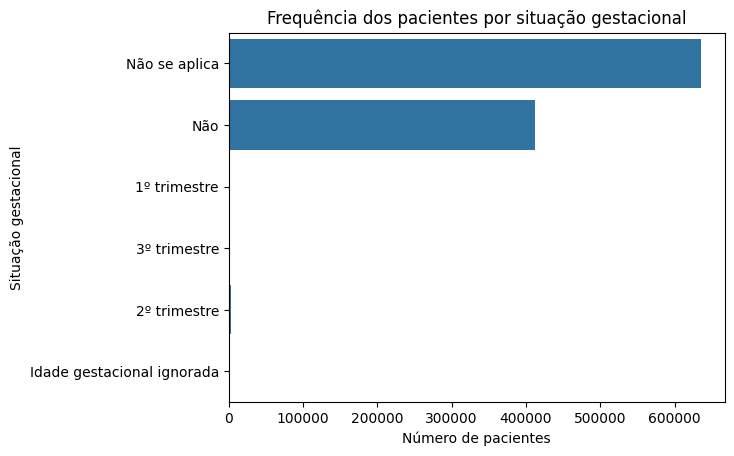

In [47]:
# Barplot da variável de situaçao gestacional
sns.countplot(df, y = 'CS_GESTANT_LABEL')
plt.title("Frequência dos pacientes por situação gestacional")
plt.xlabel("Número de pacientes")
plt.ylabel("Situação gestacional")
plt.show()

### Criaçao da variável binária de gestação:

Considerei “Sim” apenas quem está gestante (independente do trimestre), e “Não” tanto para mulheres não gestantes quanto para casos que não se aplicam. A informação da categoria "não se aplica" está contida na variável sexo (masculino) ou idade (para mulheres fora da idade fértil)

In [48]:
# Criaçao da variável binária de gestação
# Define o novo mapeamento binário
gestante_bin_map = {
    '1º trimestre': 'Sim',
    '2º trimestre': 'Sim',
    '3º trimestre': 'Sim',
    'Idade gestacional ignorada': 'Sim',
    'Não': 'Não',
    'Não se aplica': 'Não',
    'Ignorado': np.nan  # será convertido para NaN
}

# Aplica o mapeamento
df['CS_GESTANT_BIN'] = df['CS_GESTANT_LABEL'].map(gestante_bin_map)


**Tabela com frequências e porcentagens da variável gestante binária**

In [49]:
# Tabela com frequências e porcentagens da variável gestante binária
Abs_freq = df['CS_GESTANT_BIN'].value_counts(dropna = False)
rel_freq = df['CS_GESTANT_BIN'].value_counts(normalize=True, dropna=False) * 100
freq_table = pd.DataFrame({
    'Frequência': abs_freq,
    'Porcentagem (%)': rel_freq.round(2)
})
print(f"\n===Variável Gestante binária ('CS_GESTANTE_BIN'):===")
print(freq_table)











===Variável Gestante binária ('CS_GESTANTE_BIN'):===
     Frequência  Porcentagem (%)
Não     1133584            91.88
Sim        6375             0.80
NaN          51             7.32


**Barplot com porcentagens das categorias da variável gestante binária**

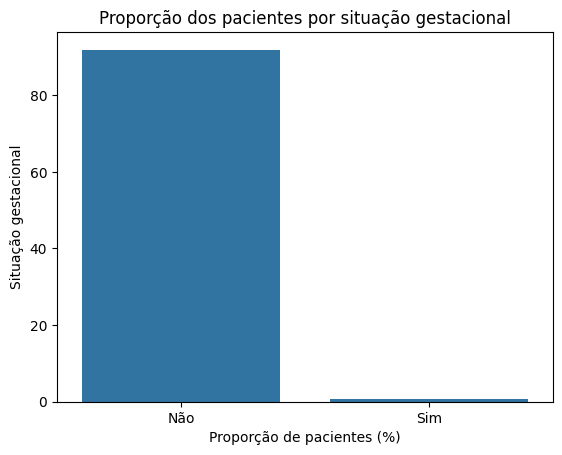

In [50]:
# Barplot da variavel de gestaçao binária
sns.countplot(df, x = 'CS_GESTANT_BIN', stat = 'percent')
plt.title("Proporção dos pacientes por situação gestacional")
plt.xlabel("Proporção de pacientes (%)")
plt.ylabel("Situação gestacional")
plt.show()

**Barplot representando as proporções de pacientes com comorbidades**. Podemos observar que hipertensão e diabetes possuem uma proporção muito mias alta do que as demais comorbidades

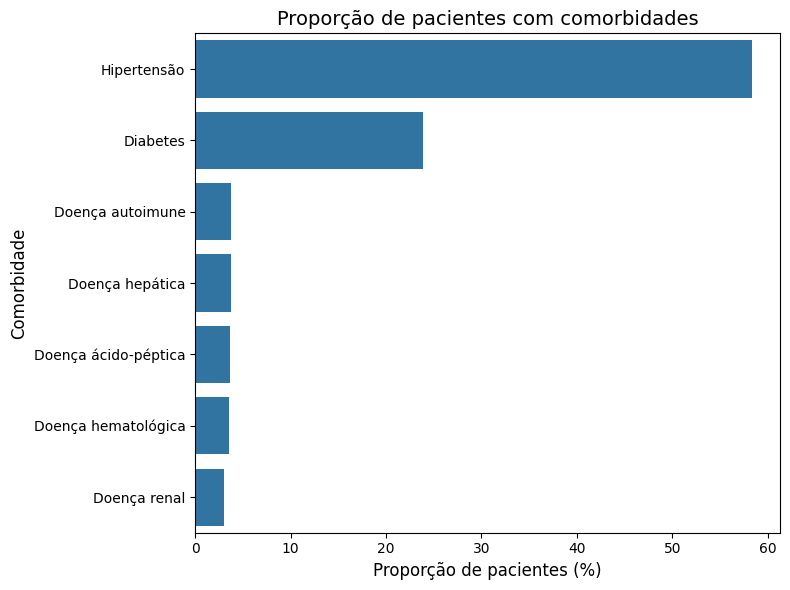

In [51]:
# Barplot das comorbidades
# Lista de variáveis de comorbidades (excluindo gestantes)
comorb_vars = [
    'DIABETES_LABEL',
    'HEMATOLOG_LABEL',
    'HEPATOPAT_LABEL',
    'RENAL_LABEL',
    'HIPERTENSA_LABEL',
    'ACIDO_PEPT_LABEL',
    'AUTO_IMUNE_LABEL'
]

# Mapeamento para nomes amigáveis
comorb_label_map = {
    'DIABETES':       'Diabetes',
    'HEMATOLOG':      'Doença hematológica',
    'HEPATOPAT':      'Doença hepática',
    'RENAL':          'Doença renal',
    'HIPERTENSA':     'Hipertensão',
    'ACIDO_PEPT':     'Doença ácido-péptica',
    'AUTO_IMUNE':     'Doença autoimune'
}

# Transformar em formato longo
df_comorb = (
    df[comorb_vars]
    .melt(var_name='Comorbidade', value_name='Presença')
)
df_comorb['Comorbidade'] = (
    df_comorb['Comorbidade']
    .str.replace('_LABEL', '', regex=False)
    .map(comorb_label_map)
)

# Filtrar apenas os 'Sim'
df_comorb_sim = df_comorb[df_comorb['Presença'] == 'Sim']

# Plotar proporção por comorbidade
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_comorb_sim,
    y='Comorbidade',
    order=df_comorb_sim['Comorbidade'].value_counts().index,
    stat='percent'
)
plt.title('Proporção de pacientes com comorbidades', fontsize=14)
plt.xlabel('Proporção de pacientes (%)', fontsize=12)
plt.ylabel('Comorbidade', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## Análise de Sinais, Sintomas e Exames Laboratoriais

Manifestações clínicas iniciais que compõem o quadro agudo:

FEBRE: Indica a presença de febre (1 para sim, 2 para não).

MIALGIA: Indica a presença de mialgia (dor muscular).

CEFALEIA: Indica a presença de cefaleia (dor de cabeça).

EXANTEMA: Indica a presença de exantema (erupção cutânea).

VOMITO: Indica a presença de vômito.

NAUSEA: Indica a presença de náusea.

DOR_COSTAS: Indica a presença de dor nas costas.

CONJUNTVIT: Indica a presença de conjuntivite.

ARTRITE: Indica a presença de artrite.

ARTRALGIA: Indica a presença de artralgia (dor nas articulações).

PETEQUIA_N: Indica a presença de petequia (manchas vermelhas na pele).

LEUCOPENIA: Indica a presença de leucopenia (baixa contagem de leucócitos).

LACO: Indica a presença de sinal do laço (prova do laço positiva).

DOR_RETRO: Indica a presença de dor retro-orbitária.

###Frequencias absolutas e porcentagens das categorias das variávies do grupo dos sinais, sintomas e exames laboratoriais

Podemos observar que todas as variáves são binárias (sim/não)

In [52]:
# Rótulos das variávei do grupo de sintomas
map_binario = {1: 'Sim', 2: 'Não', 9: np.nan}

cat_vars_sint = [
    'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO',
    'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE',
    'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO'
]

# Aplicar os mapeamentos

for var in cat_vars_sint:
    df[f'{var}_LABEL'] = df[var].map(map_binario)

In [53]:
# Tabelas de frequencias e porcentagens das vairaveis de sintomas
# Dicionário: nome da variável: rótulo legível
var_labels = {
    "FEBRE_LABEL":        "Febre",
    "MIALGIA_LABEL":      "Mialgia",
    "CEFALEIA_LABEL":     "Cefaleia",
    "EXANTEMA_LABEL":     "Exantema",
    "VOMITO_LABEL":       "Vômito",
    "NAUSEA_LABEL":       "Náusea",
    "DOR_COSTAS_LABEL":   "Dor nas costas",
    "CONJUNTVIT_LABEL":   "Conjuntivite",
    "ARTRITE_LABEL":      "Artrite",
    "ARTRALGIA_LABEL":    "Artralgia",
    "PETEQUIA_N_LABEL":   "Petéquias",
    "LEUCOPENIA_LABEL":   "Leucopenia",
    "LACO_LABEL":         "Prova do laço positiva",
    "DOR_RETRO_LABEL":    "Dor retro-orbital",
}

# Lista das variáveis de sintomas rotuladas
cat_vars_sint_label = [
    'FEBRE_LABEL', 'MIALGIA_LABEL', 'CEFALEIA_LABEL', 'EXANTEMA_LABEL',
    'VOMITO_LABEL', 'NAUSEA_LABEL', 'DOR_COSTAS_LABEL', 'CONJUNTVIT_LABEL',
    'ARTRITE_LABEL', 'ARTRALGIA_LABEL', 'PETEQUIA_N_LABEL', 'LEUCOPENIA_LABEL',
    'LACO_LABEL', 'DOR_RETRO_LABEL'
]

# Exibir frequências absolutas e percentuais
for var in cat_vars_sint_label:
    print(f"\n=== {var_labels.get(var, var)} ({var}) ===")

    abs_freq = df[var].value_counts(dropna=False)
    rel_freq = df[var].value_counts(normalize=True, dropna=False) * 100

    freq_table = (
        pd.DataFrame({
            'Frequência': abs_freq,
            'Porcentagem (%)': rel_freq.round(2)
        })
    )

    print(freq_table)



=== Febre (FEBRE_LABEL) ===
             Frequência  Porcentagem (%)
FEBRE_LABEL                             
Sim              972412             85.3
Não              167547             14.7
NaN                  51              0.0

=== Mialgia (MIALGIA_LABEL) ===
               Frequência  Porcentagem (%)
MIALGIA_LABEL                             
Sim                901831            79.11
Não                238128            20.89
NaN                    51             0.00

=== Cefaleia (CEFALEIA_LABEL) ===
                Frequência  Porcentagem (%)
CEFALEIA_LABEL                             
Sim                 897670            78.74
Não                 242289            21.25
NaN                     51             0.00

=== Exantema (EXANTEMA_LABEL) ===
                Frequência  Porcentagem (%)
EXANTEMA_LABEL                             
Não                 973451            85.39
Sim                 166508            14.61
NaN                     51             0.00

=== Vôm

**Barplot representando as proporções das variáves**.

Podemos observar que febre, mialgia e cefaléia são os sintomas mais frequentes.

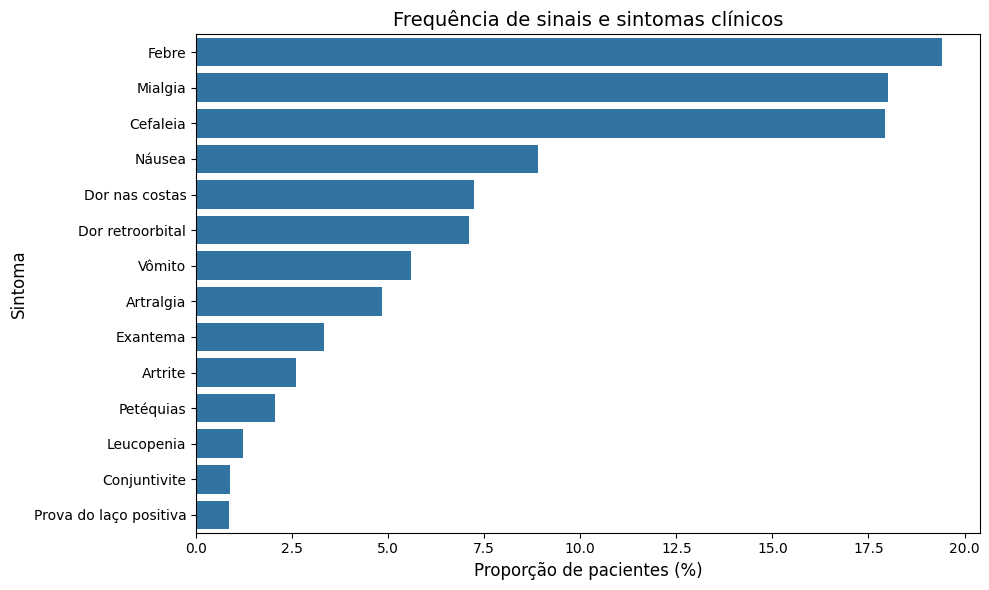

In [54]:
# Barplot representando as proporções das variáves
# Lista das variáveis com
cat_vars_sint_label = [
    'FEBRE_LABEL', 'MIALGIA_LABEL', 'CEFALEIA_LABEL', 'EXANTEMA_LABEL',
    'VOMITO_LABEL', 'NAUSEA_LABEL', 'DOR_COSTAS_LABEL', 'CONJUNTVIT_LABEL',
    'ARTRITE_LABEL', 'ARTRALGIA_LABEL', 'PETEQUIA_N_LABEL', 'LEUCOPENIA_LABEL',
    'LACO_LABEL', 'DOR_RETRO_LABEL'
]

# Mapeamento para nomes amigáveis
label_map = {
    'FEBRE': 'Febre',
    'MIALGIA': 'Mialgia',
    'CEFALEIA': 'Cefaleia',
    'EXANTEMA': 'Exantema',
    'VOMITO': 'Vômito',
    'NAUSEA': 'Náusea',
    'DOR_COSTAS': 'Dor nas costas',
    'CONJUNTVIT': 'Conjuntivite',
    'ARTRITE': 'Artrite',
    'ARTRALGIA': 'Artralgia',
    'PETEQUIA_N': 'Petéquias',
    'LEUCOPENIA': 'Leucopenia',
    'LACO': 'Prova do laço positiva',
    'DOR_RETRO': 'Dor retroorbital'
}

# Transformar para formato longo
df_melt = df[cat_vars_sint_label].melt(var_name='Sintoma', value_name='Presença')
df_melt['Sintoma'] = df_melt['Sintoma'].str.replace('_LABEL', '', regex=False)
df_melt['Sintoma'] = df_melt['Sintoma'].map(label_map)

# Filtrar apenas os sintomas positivos
df_sim = df_melt[df_melt['Presença'] == 'Sim']

# Plotagem
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sim, y='Sintoma', order=df_sim['Sintoma'].value_counts().index, stat = 'percent')
plt.title('Frequência de sinais e sintomas clínicos', fontsize=14)
plt.xlabel('Proporção de pacientes (%)', fontsize=12)
plt.ylabel('Sintoma', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## Matriz de correlações

Para explorar as associações entre as variáveis — uma numérica (idade) e várias categóricas (binárias e multicategorias) — utilizamos a função associations() da biblioteca dython.

Preparação: as colunas foram separadas em três listas (numéricas, binárias, multicategorias).

Métricas aplicadas:

- Pearson r para pares numérico × numérico (irrelevante aqui, pois só há uma variável numérica).

- Correlação-razão para pares multicategoria × numérico.

- Cramér V para todo o par categórico-categórico

Tratamento de faltantes: adotou-se pair-wise deletion (nan_strategy='drop_sample_pairs'), descartando apenas as linhas ausentes no par analisado.

Visualização: os coeficientes variam de 0 (nenhuma associação) a 1 (associação perfeita); como Cramér V e correlação-razão são não-direcionais, apenas a força da relação é interpretada.


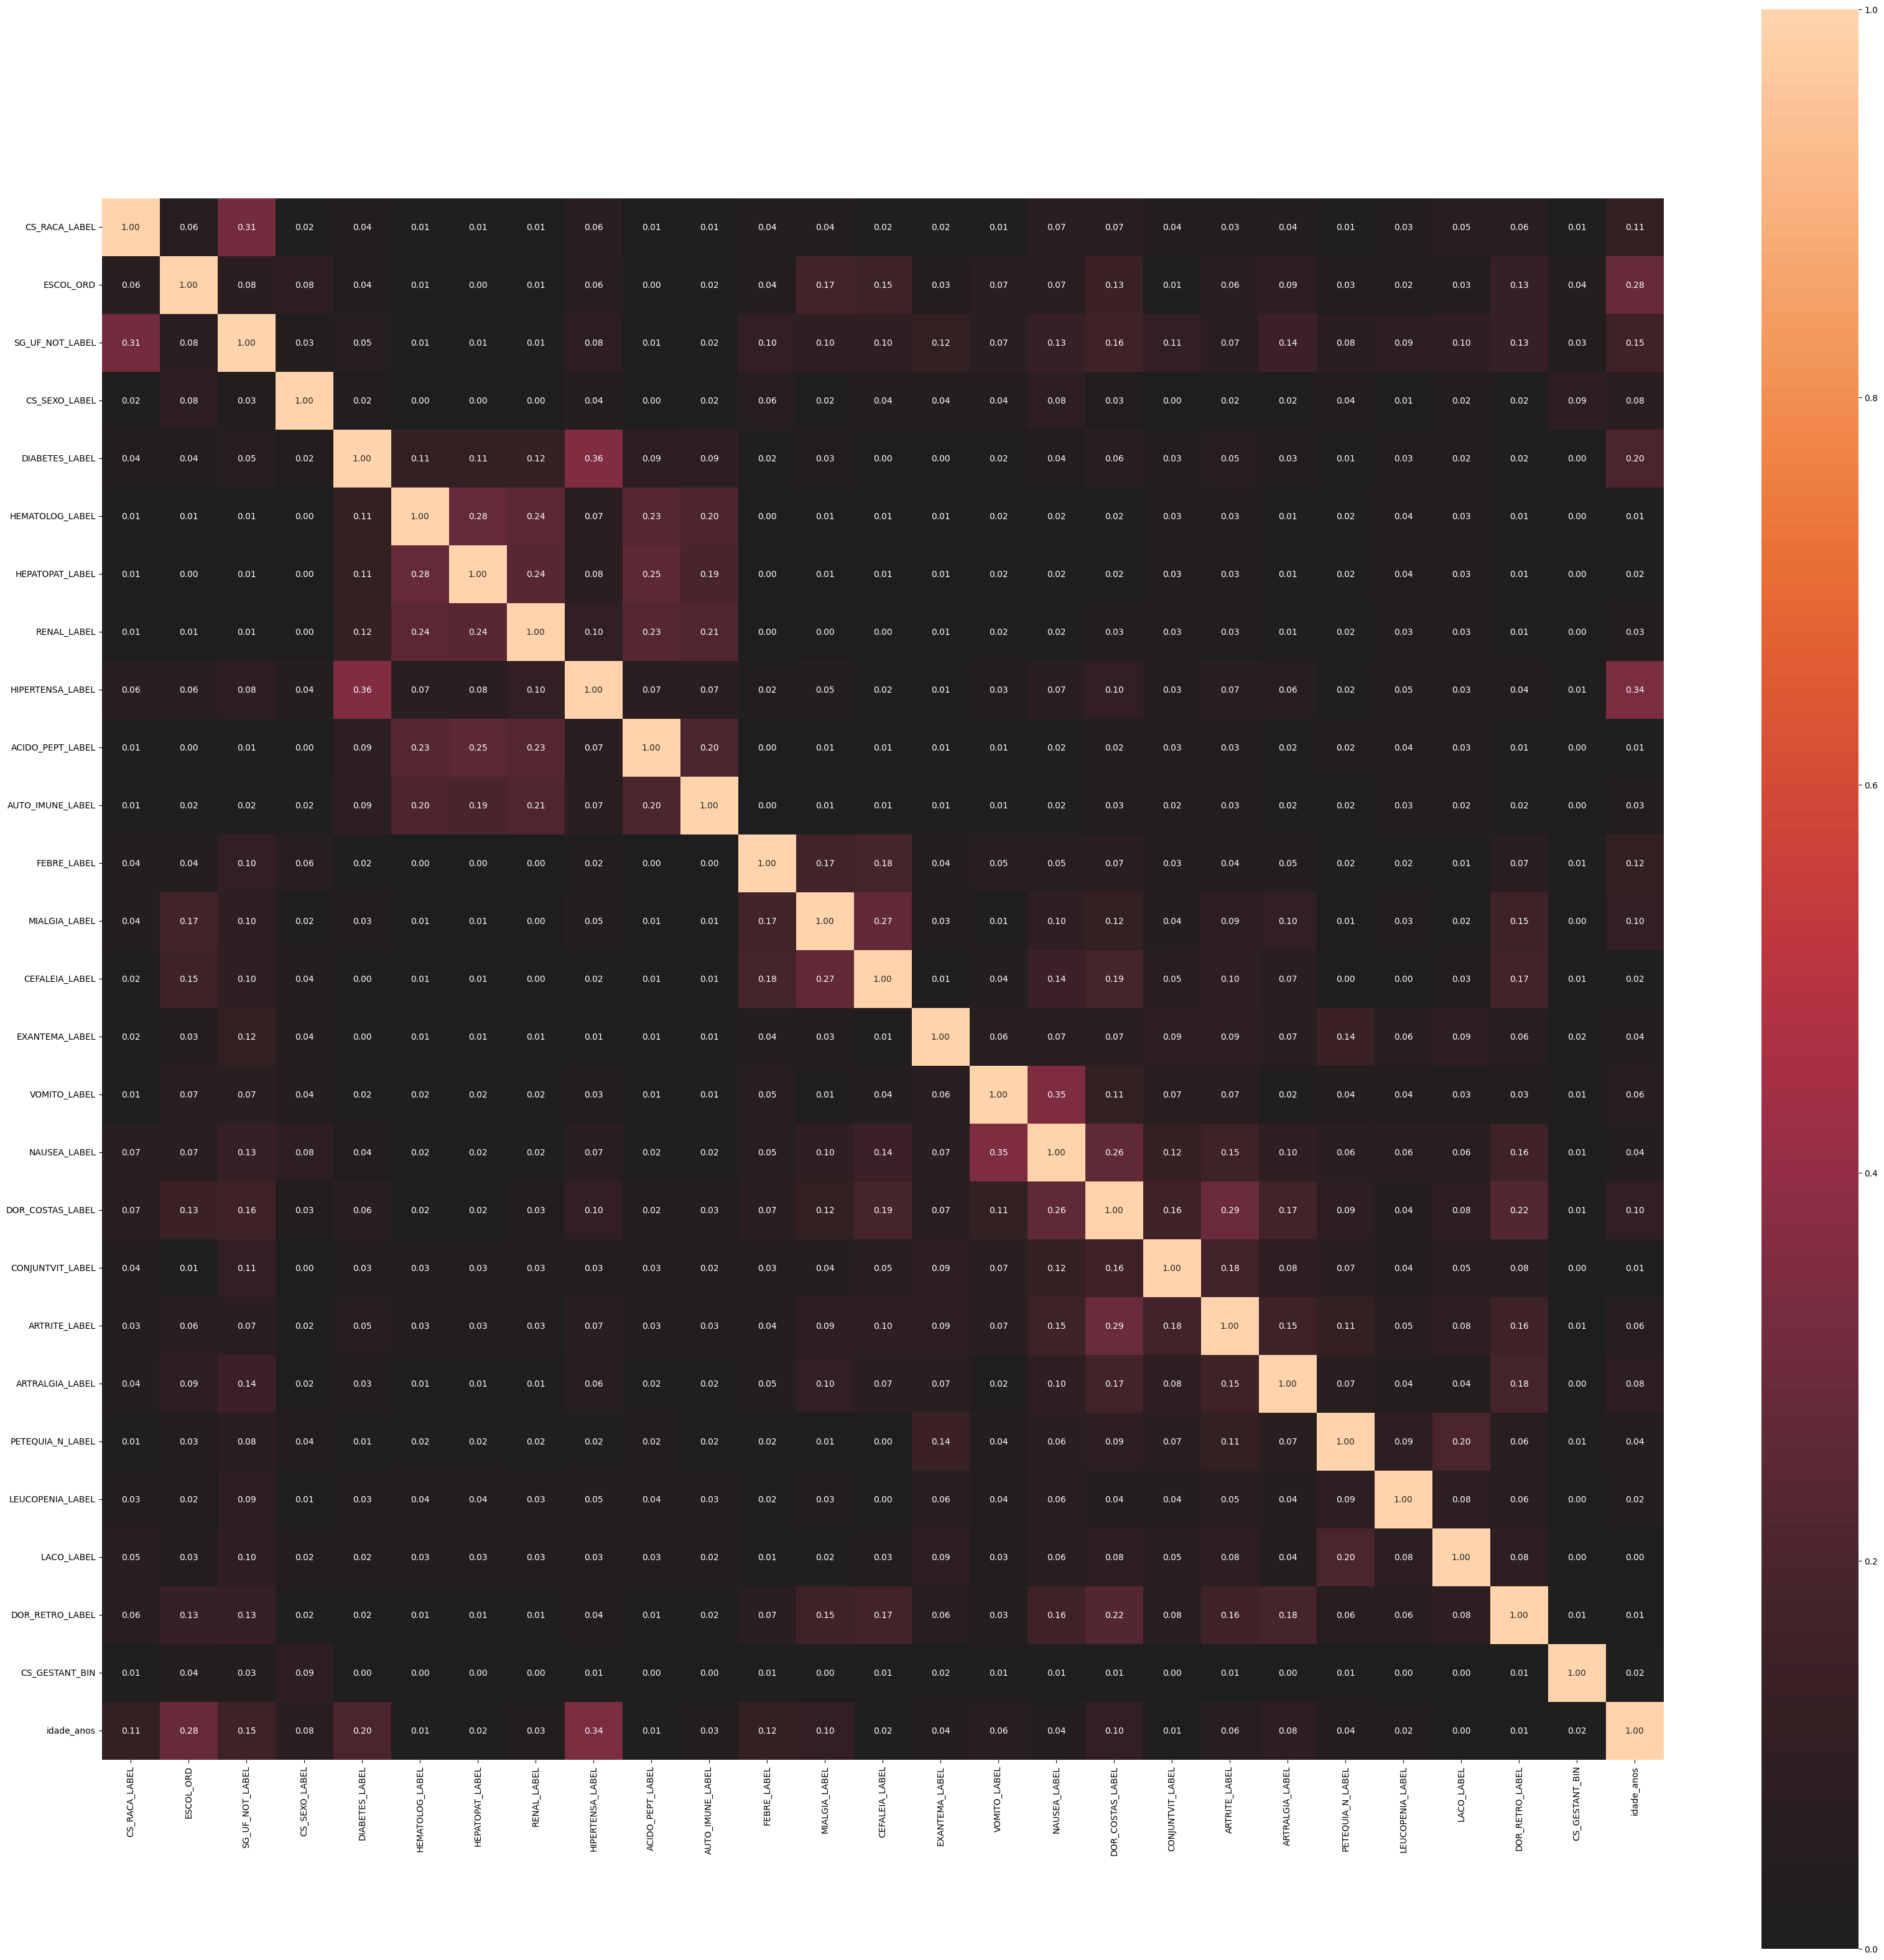

In [55]:
# Declaração dos grupos de variáveis
multicategoricas = [
    'CS_RACA_LABEL', 'ESCOL_ORD', 'SG_UF_NOT_LABEL'
]

binarias = ['CS_SEXO_LABEL', 'DIABETES_LABEL', 'HEMATOLOG_LABEL', 'HEPATOPAT_LABEL', 'RENAL_LABEL',
    'HIPERTENSA_LABEL', 'ACIDO_PEPT_LABEL', 'AUTO_IMUNE_LABEL',
    'FEBRE_LABEL', 'MIALGIA_LABEL', 'CEFALEIA_LABEL', 'EXANTEMA_LABEL',
    'VOMITO_LABEL', 'NAUSEA_LABEL', 'DOR_COSTAS_LABEL', 'CONJUNTVIT_LABEL',
    'ARTRITE_LABEL', 'ARTRALGIA_LABEL', 'PETEQUIA_N_LABEL', 'LEUCOPENIA_LABEL',
    'LACO_LABEL', 'DOR_RETRO_LABEL', 'CS_GESTANT_BIN'
]

numericas = ['idade_anos']

cols_keep = multicategoricas + binarias + numericas

df_corr   = df[cols_keep].copy()


# Matriz de correlações
_= associations(
    df_corr,
    nominal_columns = multicategoricas + binarias,
    nom_nom_assoc   = 'cramer',
    nan_strategy    = 'drop_sample_pairs',
    plot            = True
)



No nosso conjunto, o valor máximo de correlação foi 0.36, o que indica que não há multicolinearidade forte entre as variáveis (geralmente considerada significativa quando os valores ultrapassam 0.50).

Além disso, observamos que as correlações mais altas fazem sentido clinicamente. A associação entre hipertensão e diabetes, e entre ambas e a idade, é bem caracterizada epidemiologicamente. Também é esperado que náuseas (enjôo) e vômitos apresentem correlação, pois são manifestações clínicas frequentemente concomitantes. O mesmo vale para a correlação entre petéquias e prova do laço positiva, já que ambas refletem sinais de sangramento cutâneo, típicos de quadros hemorrágicos da dengue.

# Pré-processamento de dados
Preperacão dos dados para modelagem

Na análise expliratória pudemos observar que as variáveis clinicas (sintomas e comorbidades) tem 51 valores faltantes. Vou verificar se correspondem a os mesmos pacientes.

In [56]:
clin_vars = ['DIABETES_LABEL', 'HEMATOLOG_LABEL', 'HEPATOPAT_LABEL',
    'RENAL_LABEL', 'HIPERTENSA_LABEL', 'ACIDO_PEPT_LABEL', 'AUTO_IMUNE_LABEL',
    'FEBRE_LABEL', 'MIALGIA_LABEL', 'CEFALEIA_LABEL', 'EXANTEMA_LABEL',
    'VOMITO_LABEL', 'NAUSEA_LABEL', 'DOR_COSTAS_LABEL', 'CONJUNTVIT_LABEL',
    'ARTRITE_LABEL', 'ARTRALGIA_LABEL', 'PETEQUIA_N_LABEL',
    'LEUCOPENIA_LABEL', 'LACO_LABEL', 'DOR_RETRO_LABEL'
]

total_all_na = df[clin_vars].isna().all(axis=1).sum()
print("Linhas com NA em todas as variáveis clínicas:", total_all_na)


Linhas com NA em todas as variáveis clínicas: 51


Esse pacientes com todas as variáveis clínicas ausentes serão excluídos

In [57]:
# Exclusão dos pacientes sem variáveis clinicas
df = df.dropna(subset=clin_vars, how='all').copy()

In [58]:
total_all_na2 = df[clin_vars].isna().all(axis=1).sum()
print("Linhas com NA em todas as variáveis clínicas após exclusão:", total_all_na2)

Linhas com NA em todas as variáveis clínicas após exclusão: 0


Valores ausentes nas variáveis demográficas:

In [59]:
cols_demog = ['idade_anos',
             'CS_SEXO_LABEL',
             'CS_RACA_LABEL',
             'ESCOL_ORD',
             'SG_UF_NOT_LABEL']

print("Contagem de valores ausentes")
df[cols_demog].isna().sum().to_frame('NA')

Contagem de valores ausentes


,NA
idade_anos,92
CS_SEXO_LABEL,988
CS_RACA_LABEL,202134
ESCOL_ORD,561502
SG_UF_NOT_LABEL,0


Como já foi demonstrado anteriormente, quase todas as variáveis demográficas tem valores ausentes, com destaque para a escolaridade e cor/raça. Isso será abordado nas próximas etapas do pré-processamento.


Primeiramente serão definidos grupos de variáveis conforme seu tipo: numéricas (idade_anos), binárias (sintomas e comorbidades), categóricas nominais (raça e UF) e categórica ordinal (escolaridade). Essa separação organiza as variáveis para transfomacões específicas de cada grupo no pré-processamento.

In [60]:
# Listagem das variáveis
num_vars = ['idade_anos']

bin_vars = [
    'CS_SEXO_LABEL', 'CS_GESTANT_BIN',
    'DIABETES_LABEL', 'HEMATOLOG_LABEL', 'HEPATOPAT_LABEL',
    'RENAL_LABEL', 'HIPERTENSA_LABEL', 'ACIDO_PEPT_LABEL', 'AUTO_IMUNE_LABEL',
    'FEBRE_LABEL', 'MIALGIA_LABEL', 'CEFALEIA_LABEL', 'EXANTEMA_LABEL',
    'VOMITO_LABEL', 'NAUSEA_LABEL', 'DOR_COSTAS_LABEL', 'CONJUNTVIT_LABEL',
    'ARTRITE_LABEL', 'ARTRALGIA_LABEL', 'PETEQUIA_N_LABEL',
    'LEUCOPENIA_LABEL', 'LACO_LABEL', 'DOR_RETRO_LABEL'
]

cat_vars = ['CS_RACA_LABEL', 'SG_UF_NOT_LABEL']
ord_vars = ['ESCOL_ORD']

Em seguida, serão definidos pipelines de pré-processamento usando as classes Pipeline e ColumnTransformer da biblioteca scikit-learn. Cada Pipeline aplica uma sequência de etapas a um tipo específico de variável:

- Para variáveis numéricas, imputação pela mediana e padronização (StandardScaler);

- Para binárias e categóricas, imputação com 'Desconhecido' para valores ausentes (criando uma nova categoria) e codificação one-hot (OneHotEncoder);

- Para a variável ordinal, codificação hierárquica com OrdinalEncoder, atribuindo −1 a valores ausentes.

O ColumnTransformer combina esses pipelines aos respectivos grupos de colunas no dataset.


In [61]:
# Pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

bin_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('ohe',     OneHotEncoder(drop='if_binary', sparse_output= False))
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output= False))
])

ord_pipe = Pipeline([
    ('ordenc', OrdinalEncoder(
        categories=[[
            'EF incompleto', 'EF completo',
            'EM incompleto', 'EM completo',
            'Superior incompleto', 'Superior completo'
        ]],
        handle_unknown='use_encoded_value',   # qualquer valor fora da lista
        unknown_value=-1,                     # inclusive NaN → −1
        dtype='int8'
    ))
])

preprocess = ColumnTransformer([
    ('num',  num_pipe, num_vars),
    ('bin',  bin_pipe, bin_vars),
    ('cat',  cat_pipe, cat_vars),
    ('ord',  ord_pipe, ord_vars)
])

O trecho a seguir separa os dados em conjuntos de treino e teste com a função train_test_split do scikit-learn. A matriz de preditores X é composta por todas as variáveis listadas, e y representa o desfecho ('CLASS'). A divisão reserva 20% dos dados para teste (test_size=0.20), mantém a proporção das classes (stratify=y) e fixa a aleatoriedade com random_state=42 para garantir reprodutibilidade.

In [62]:
# Split hold-out
X = df[num_vars + bin_vars + cat_vars + ord_vars]
y = df['CLASS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

Em seguida será feita uma inspeção manual do pré-processamento.

O proximo bloco aplica os pipelines aos dados de treino e exibe o resultado como um DataFrame, preservando os nomes das colunas.

As opções do pandas são então ajustadas para mostrar todas as linhas e colunas (transpostas para leitura mais clara) e, ao fim, restaura-se a saída padrão.


In [63]:
# Dataframe para inspeçao do pré-processamento
set_config(transform_output="pandas")

prep = preprocess.fit(X_train) # Ajuste do pipeline aos dados de treino

# Dataframe
df_pre = pd.DataFrame(
    prep.transform(X_train),
    columns=prep.get_feature_names_out()
)

# Visualizar: features em linhas, 5 primeiras amostras em colunas
pd.set_option("display.max_rows",    None)
pd.set_option("display.max_columns", 5)
pd.set_option("display.width",       None)

print("Primeiras linhas do dataset pré-processado:")
display(df_pre.head().T)

set_config(transform_output="default")

Primeiras linhas do dataset pré-processado:


,1099727,852683,902792,190145,861133
num__idade_anos,0.189746,0.746356,0.240347,1.657174,1.049962
bin__CS_SEXO_LABEL_Desconhecido,0.000000,0.000000,0.000000,0.000000,0.000000
bin__CS_SEXO_LABEL_Feminino,0.000000,1.000000,0.000000,0.000000,1.000000
bin__CS_SEXO_LABEL_Masculino,1.000000,0.000000,1.000000,1.000000,0.000000
bin__CS_GESTANT_BIN_Desconhecido,0.000000,0.000000,0.000000,0.000000,0.000000
bin__CS_GESTANT_BIN_Não,1.000000,1.000000,1.000000,1.000000,1.000000
bin__CS_GESTANT_BIN_Sim,0.000000,0.000000,0.000000,0.000000,0.000000
bin__DIABETES_LABEL_Sim,0.000000,0.000000,0.000000,0.000000,0.000000
bin__HEMATOLOG_LABEL_Sim,0.000000,0.000000,0.000000,0.000000,0.000000
bin__HEPATOPAT_LABEL_Sim,0.000000,0.000000,0.000000,0.000000,0.000000


Podemos verificar acima a  codificação das variáveis conforme especificado

Em seguida serão exibidos os valores nulos do dataset

In [ ]:
# Verificaçao de nulos no dataset pré-processado
print("Valores nulos no dataset:")
df_pre.isnull().sum()

Valores nulos no dataset:


,0
num__idade_anos,0
bin__CS_SEXO_LABEL_Desconhecido,0
bin__CS_SEXO_LABEL_Feminino,0
bin__CS_SEXO_LABEL_Masculino,0
bin__CS_GESTANT_BIN_Desconhecido,0
bin__CS_GESTANT_BIN_Não,0
bin__CS_GESTANT_BIN_Sim,0
bin__DIABETES_LABEL_Sim,0
bin__HEMATOLOG_LABEL_Sim,0
bin__HEPATOPAT_LABEL_Sim,0


Podemos verificar que não há valores nulos após o pré-processamento

Distribuição da idade padronizada no pré-processamento

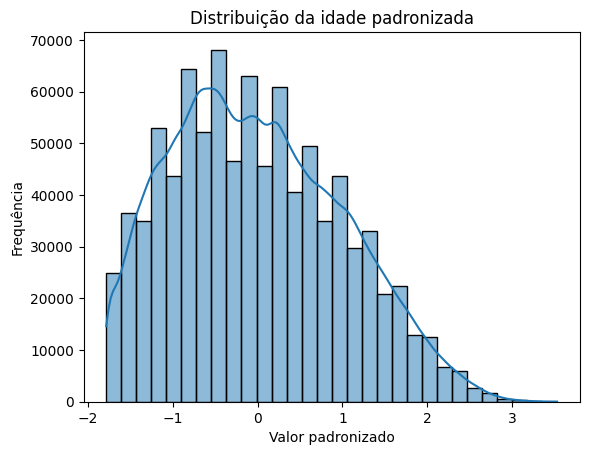

In [ ]:
# Distribuição da idade padronizada
sns.histplot(df_pre['num__idade_anos'], bins=30, kde = True)
plt.xlabel('Valor padronizado')
plt.ylabel('Frequência')
plt.title('Distribuição da idade padronizada')
plt.show()

Este trecho de código constrói e avalia um modelo de aprendizado supervisionado para prever os casos de dengue com a classificacão de gravidade. Devido às características do nosso dataset, o foco é em um problema classificação binária desbalanceada. Ele combina pré-processamento, reamostragem (oversampling) e um modelo LightGBM, tudo dentro de um pipeline validado por validação cruzada estratificada repetida.

A estrutura é criada com o Pipeline da biblioteca imbalanced-learn (ImbPipeline). Esse pipeline é importante porque permite incluir etapas que alteram o número de amostras, como o oversampling (para lidar com desbalanceamento entre as classes).

O pipeline aplica o preprocess (pré-processamento), seguido do RandomOverSampler, que replica amostras da classe  minoritária para balancear a distribuição (apenas nos conjuntos de treino para evitar vazamento de informação). Por fim, treina um LGBMClassifier, modelo eficiente baseado em árvores de decisão.

A validação do modelo é feita por validação cruzada estratificada repetida, com RepeatedStratifiedKFold, que garante que a proporção das classes seja preservada em cada fold. O conjunto de dados é dividido em 5 partes. O modelo é então treinado em 4 dessas partes e testado na parte restante. Esse processo é repetido 3 vezes. No final, as métricas são agregadas (PR-AUC, recall, precisão e F1).



In [66]:
# Definição do pipeline completo

pipeline_ros = ImbPipeline([
    ('prep', preprocess),                         # Pré-processamento
    ('ros',  RandomOverSampler(random_state=42)), # Oversampling
    ('clf',  LGBMClassifier(                      # Modelo
                 objective='binary',
                 n_estimators=400,
                 random_state=42
             ))
])

# Configuração da validação cruzada

cv = RepeatedStratifiedKFold(n_splits=5, # Numero de partes
                             n_repeats=3, # Numero de repetições
                             random_state=42)

# Múltiplas métricas
scoring = {
    'pr_auc': 'average_precision',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1'
}

# Avaliação
cv_res = cross_validate(
    pipeline_ros, X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Mostrar resultados
for metric in scoring.keys():
    vals = cv_res[f'test_{metric}']
    print(f"{metric.upper()} média (CV): {vals.mean():.3f} ± {vals.std():.3f}")

PR_AUC média (CV): 0.016 ± 0.004
RECALL média (CV): 0.394 ± 0.026
PRECISION média (CV): 0.009 ± 0.001
F1 média (CV): 0.018 ± 0.001


Podemos observar que mesmo após o oversampling, o modelo ainda necessita de ajustes adicionais para se tornar clinicamente útil. Uma análise detalhada das métricas, os ajustes necessários e a  avlaiação no hold-out externo (X_test) fogem dos objetivos desse MVP.

# Conclusão

Este exercício demonstrou um pipeline completo de análise e pré-processamento de dados aplicados a um problema real de saúde pública: a predição da evolução para formas graves de dengue. A partir de uma base nacional de notificações (SINAN), filtrei e organizei os dados, identifiquei variáveis relevantes e realizei transformacões e tratemento de valores ausentes nas variáveis selecionadas. Explorei também técnicas para lidar com desbalanceamento de classes e avaliei o desempenho inicial do modelo com validação cruzada estratificada. Apesar dos desafios inerentes à base de dados, os resultados obtidos reforçam o potencial de modelos preditivos no apoio à vigilância e gestão de casos de dengue.

